# import + funcs

In [24]:
import pandas as pd
import os
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import json
import statsmodels.regression.linear_model as sm
import ast
import warnings
import pickle


def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()

# ignore only deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def reactivation_per_minute(nrem_filtered_chunk_data, nrem_state_times):
    # save out data
    reactivations_found = len(nrem_filtered_chunk_data)

    if len(nrem_state_times) > 0:
        mins = sum(np.diff(nrem_state_times))[0]
    else:
        mins = 0
        
    # convert to mins            
    mins = mins/60

    if mins > 0:
        return reactivations_found/mins
    else:
        return np.nan
    
def define_spindle_linkage(spindle_start_events,spindle_end_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for i,spin_start in enumerate(spindle_start_events):
            s_distance = abs(spin_start - event)
            e_distance = abs(spindle_end_events[i] - event)
            if s_distance < abs(current_shortest_dist):
                current_shortest_dist = s_distance
            elif e_distance < abs(current_shortest_dist):
                current_shortest_dist = e_distance
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def return_spindle_linkage_masks(file, filtered_chunk_data, spindle_events, time_spans, linkage_distance,non_linked_distance):

    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # put these back in proper ephys time:
    fs_event_times = fs_event_times + time_spans[chunk_number-1][0]
    # get spindle times
    spindle_start_times = [event['start_time'] for event in spindle_events]
    spindle_end_times = [event['end_time'] for event in spindle_events]
    # spindle distances
    absolute_spindle_distances = abs(np.array(define_spindle_linkage(spindle_start_times,spindle_end_times,fs_event_times)))
    # get the linked and unlinked masks
    linked_mask = absolute_spindle_distances < 1.5
    not_linked_mask = absolute_spindle_distances > 2.5
    
    return linked_mask, not_linked_mask

def return_binned_replay_rate(file, filtered_chunk_data, time_spans, current_sleep_start):
    chunk_number = int(file.split('_')[0][-1])
    chunk_start_offset = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
    # make relative to start of chunk
    fs_event_times = filtered_chunk_data['first_spike_time'].values - chunk_start_offset
    # put these back in proper ephys time:
    fs_event_times = fs_event_times + time_spans[chunk_number-1][0]
    # now make relative to sleep start time
    f_spike_times_relative_to_so = fs_event_times - current_sleep_start 
    # filter out anything that happened before sleep onset
    f_spike_times_relative_to_so = f_spike_times_relative_to_so[f_spike_times_relative_to_so > 0]

    ## calculate rate over time:
    time_data = pd.Series(f_spike_times_relative_to_so)
    if len(time_data) > 0:
        # Calculate the number of bins required # 20s bins
    #     num_bins = int((time_data.max() - time_data.min()) // 40 + 1)
        if time_data.max() - time_data.min() > 19:
            num_bins = int((time_data.max() - time_data.min())//20)
            # Create bins and count the occurrences in each bin
            chunk_event_rate, chunk_relative_time_bins = np.histogram(time_data, bins=num_bins)
            #remove extra final bin and convert to mins
            chunk_relative_time_bins = chunk_relative_time_bins[0:-1]/60
            
            binned_rate = [list((chunk_event_rate*3).astype(float))] # *3 because its per 20s so we want it per minute )
            bins_relative_so = [list(chunk_relative_time_bins.astype(float))]
            
            return binned_rate,bins_relative_so
        return np.nan, np.nan
    return np.nan, np.nan

def load_start_end_dfs(mouse,start_end_df,mask,current_data_path_temporal_structre,chunk_number):
    try:
        ## start stop points
        df_load = pd.read_csv(current_data_path_temporal_structre+'start_end_df.csv',index_col=0)
        
        starts = df_load[df_load.group == 'starts'].reset_index(drop=True)[mask]
        ends = df_load[df_load.group == 'ends'].reset_index(drop=True)[mask]
        df_filtered = pd.concat([starts, ends], axis=0)
        df_filtered['mouse'] = [mouse]*len(df_filtered)
        df_filtered['chunk_number'] = [chunk_number]*len(df_filtered)
        start_end_df = pd.concat((start_end_df,df_filtered),axis =0)
        start_end_df.reset_index(drop = True)
    except:
        print('no start stops points available')
    return start_end_df

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def relative_dict(input_dict):
    total_sum = sum(input_dict.values())
    relative_dict = {key: value / total_sum for key, value in input_dict.items()}
    return relative_dict

def determine_relative_coactivity_per_chunk(filtered_chunk_data, event_proximity_filter, coactive_freqs_chunk):

    ### ignore the origonal clusterg rosp and remake them: 
    start_times = filtered_chunk_data.first_spike_time.values
    end_times = filtered_chunk_data.last_spike_time.values

    clustered_events = cluster_events(start_times, end_times,event_proximity_filter)

    cluster_group = np.zeros(len(filtered_chunk_data))
    for index,cluster in enumerate(clustered_events):
        for item in cluster:
            cluster_group[item] = int(index)
    filtered_chunk_data_coactive = filtered_chunk_data.copy()
    filtered_chunk_data_coactive['coactive_cluster_group'] = cluster_group

    # work out how mnay coacitve in chunk: 
    current_coactive_freqs_chunk = {}
    for cluster in filtered_chunk_data_coactive.coactive_cluster_group.unique():
        num = list(filtered_chunk_data_coactive.coactive_cluster_group.values).count(cluster)
        if num in current_coactive_freqs_chunk:
            current_coactive_freqs_chunk[num] += 1
        else:
            current_coactive_freqs_chunk[num] = 1

    avs =[]
    for item in current_coactive_freqs_chunk:
        avs += current_coactive_freqs_chunk[item] * [item]
    # av_coactive_len_per_chunk += [np.mean(avs)]

    # make it relative:
    current_coactive_freqs_chunk = relative_dict(current_coactive_freqs_chunk)
    coactive_freqs_keys = list(current_coactive_freqs_chunk.keys())
    rel_coactive_freqs = list(current_coactive_freqs_chunk.values())
    for index,item in enumerate(rel_coactive_freqs):
        num = int(coactive_freqs_keys[index])
        if num in coactive_freqs_chunk:
            coactive_freqs_chunk[num] += [item]
        else:
            coactive_freqs_chunk[num] = [item]
            
    return coactive_freqs_chunk


def create_multicluster_dataframe(filtered_chunk_data):
    meaned_order = []
    fs_order = []
    event_times = []
    count = 0
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            means = []
            event_types = []
            fs_orders = []
            for index,events in enumerate(current_cluster.cluster_spike_times):
                event_types += [current_cluster.cluster_seq_type.values[index]]
                # calculate event order based on spike time weighted mean
                means += [np.mean(ast.literal_eval(events))]
                # calculate order based on first spike time:
                fs_orders += [current_cluster.first_spike_time.values[index]]

            # order by mean time:    
            meaned_order += [list(np.array(event_types)[np.argsort(means)])]
            # order by first spike:
            fs_order += [list(np.array(event_types)[np.argsort(fs_orders)])]

            event_times += [fs_orders]

            current_cluster['new_cluster_group'] =  [count]*len(current_cluster)
            current_cluster['cluster_order_first_spike_defined'] =  list(np.argsort(np.argsort(fs_orders)))
            current_cluster['cluster_order_mean_weighted_spikes_defined'] =  list(np.argsort(np.argsort(means)))

            if count == 0:
                multi_cluster_df = current_cluster.copy()
            else:
                # Concatenate the DataFrames vertically (row-wise)
                multi_cluster_df = pd.concat([multi_cluster_df, current_cluster], axis=0)
                # Reset the index if needed
                multi_cluster_df = multi_cluster_df.reset_index(drop=True)

            count += 1
    return multi_cluster_df,meaned_order,fs_order

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                elif pair[-1] in (dominant + [item]):
                    return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def Clusters_to_process_bool(filtered_chunk_data):
    """
    Check if there are clusters with more than one event in the filtered chunk data.
    Returns True if there are such clusters, otherwise False.
    """
    # Check if any cluster has more than one event
    for i,group in enumerate(filtered_chunk_data.coactive_cluster_group.unique()):
        group_mask = filtered_chunk_data.coactive_cluster_group == group
        current_cluster = filtered_chunk_data[group_mask].copy()
        if len(current_cluster) > 1:
            return True
    return False

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

def calculate_ordering_amounts(meaned_order,dominant,other_):
    ordered = 0
    misordered = 0
    other = 0
    for cluster in meaned_order:
        for ind,item in enumerate(cluster):
            if not ind == len(cluster)-1:
                pair = [item,cluster[ind+1]]
                outcome = logic_machine_for_pair_catagorisation(pair,dominant,other_)
                if outcome in ['ordered', 'repeat', 'reverse']:
                    ordered += 1
                elif outcome == 'misordered':
                    misordered += 1
                else:
                    other +=1
    return ordered,misordered,other

def calculate_ordering_proportions(filtered_chunk_data,mouse_file, sequence_order_df):

    # make multi cluster df
    if Clusters_to_process_bool(filtered_chunk_data):
        multi_cluster_df,meaned_order,fs_order = create_multicluster_dataframe(filtered_chunk_data)
    else:
        multi_cluster_df,meaned_order,fs_order = [],[],[]

    # pull out sequence order for current mouse
    seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse_file].seq_order.values[0])
    # num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse_file].dominant_task_seqs)
    num_dominant_seqs = int(sequence_order_df.loc[sequence_order_df.mir == mouse_file, "dominant_task_seqs"].iat[0])
    
    
    real_order = np.array(seq_order)+1

    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = list(real_order[0:num_dominant_seqs])
        other_ = list(real_order[num_dominant_seqs::])
    else:
        dominant = list(real_order)
        other_ = []
        
    # orderng amounts for mean ordering - this calculated for each pair in the chunk 
    ordered,misordered,other = calculate_ordering_amounts(meaned_order,dominant,other_)

    # i only care abot ordered and misordered here, so lets just take these out:
    if ordered+misordered > 0:
        ordered_misordered_proportions = [ordered/(ordered+misordered),misordered/(ordered+misordered)]
        return ordered_misordered_proportions
    else:
        return [np.nan,np.nan]
    

def determine_task_related_events(sequential_data, sequence_order_df,mouse_file,real_order):

    task_related = 0
    non_task_related = 0
    for motif_type in sequential_data.cluster_seq_type:
        if motif_type in real_order:
            task_related += 1
        else:
            non_task_related += 1

    
    return [non_task_related, task_related]
    
def get_normalised_task_related_proportions(nrem_nontask_task_chunk,real_order):
    #flatten list
    if sum([item for sublist in nrem_nontask_task_chunk for item in sublist]) == 0:
        return [np.nan,np.nan]
    else:
        # normalise by number of each type: 
        task_related_normalised_total = sum([item[1] for item in nrem_nontask_task_chunk])/len(real_order)
        if (6-len(real_order)) == 0:
            non_task_related_normalised_total = sum([item[0] for item in nrem_nontask_task_chunk])
        else:
            non_task_related_normalised_total = sum([item[0] for item in nrem_nontask_task_chunk])/(6-len(real_order))
        normalised_total = task_related_normalised_total + non_task_related_normalised_total
        return [task_related_normalised_total/normalised_total,non_task_related_normalised_total/normalised_total]
    

def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted


def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)


def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs):

    seq_by_seq_awake_mean_neuron_motif_involvements = []
    ### determine which neurons are involved in awake seqs
    all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))
    for seq_type in range(1,7):
        # print(seq_type)
        # Determine mean neuron involvements for awake
        neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
        for awake_seq in seq_event_dfs:
            if awake_seq.sequence_type_adjusted.values[0] == seq_type:
                for id_, neuron_id in enumerate(all_neurons_list):
                    if neuron_id in awake_seq.neuron.values:
                        neuron_motif_involvements[id_].append(1)
                    else:
                        neuron_motif_involvements[id_].append(0)
        #find mean involvements:
        awake_mean_neuron_motif_involvements = []
        for item in neuron_motif_involvements:
            if len(item)>0:
                awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
            else:
                awake_mean_neuron_motif_involvements += [0]
        seq_by_seq_awake_mean_neuron_motif_involvements += [awake_mean_neuron_motif_involvements]
    return seq_by_seq_awake_mean_neuron_motif_involvements

def find_awake_file_ppseq_path(mouse,ppseq_path):
    if any([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True:
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'expert/awake', os.listdir(ppseq_path + r'expert/awake//')[file_ind])
    elif any([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True:    
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'learning/awake', os.listdir(ppseq_path + r'learning/awake//')[file_ind])
    else:
        print('awake file not found for mouse: ' + mouse)
    return awake_file_path

def determine_sleep_neuron_motif_involvements(filtered_chunk_data,unmasked_spikes_df):

    per_seq_sleep_involvement = []
    for seq in range(1,7):
        current_seq_events = filtered_chunk_data[filtered_chunk_data.cluster_seq_type == seq]
        if len(current_seq_events) > 0:
            # loop across neurons
            per_neuron_sleep_involvement = []
            for neuron in unmasked_spikes_df.neuron.unique():
                involvement = []
                for event in current_seq_events.cluster_neurons.values:
                    event = ast.literal_eval(event)
                    if neuron in event:
                        involvement += [1]
                    else:
                        involvement += [0]
                per_neuron_sleep_involvement += [sum(involvement)/len(involvement)]
            per_seq_sleep_involvement += [per_neuron_sleep_involvement]
        else:
            per_seq_sleep_involvement += [[np.nan]*len(unmasked_spikes_df.neuron.unique())]
    return per_seq_sleep_involvement
                
            



# make all the replay plots I need for spindle linkage. Also remake all of the REM v NREM plots from before.

I need all my replay features and their spindle linkage distances

In [26]:
# # dat path:
# dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"
dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

# spindle linkage path
LFP_datapath = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

# load in sleep time points
sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')
# decide when sleep started
sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    sleep_start[mouse] = value


In [ ]:
# initialize lists to hold data across animals 
nrem_reactivations_per_min, rem_reactivations_per_min = [],[]
#event lengths
nrem_event_lens,rem_event_lens,linked_event_lens,unlinked_event_lens = [],[],[],[]
# regression df
nrem_regression_df= pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
rem_regression_df= pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
linked_regression_df= pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
unlinked_regression_df= pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[]})
# decay variables 
nrem_binned_rate ,nrem_bins_relative_so = [],[]
rem_binned_rate,rem_bins_relative_so = [],[]
linked_binned_rate,linked_bins_relative_so = [],[]
unlinked_binned_rate,unlinked_bins_relative_so = [],[]
# start end points
nrem_start_end_df = pd.DataFrame({})
rem_start_end_df = pd.DataFrame({})
linked_start_end_df = pd.DataFrame({})
unlinked_start_end_df = pd.DataFrame({})
# coactive 
nrem_coactive_freqs = {}
rem_coactive_freqs = {}
linked_coactive_freqs = {}
unlinked_coactive_freqs = {}
# ordered vs misordered
nrem_ordered_misordered = []
rem_ordered_misordered = []
linked_ordered_misordered = []
unlinked_ordered_misordered = []
# task related events
nrem_task_nontask = []
rem_task_nontask = []
linked_task_nontask =[]
unlinked_task_nontask = []
# neuron involvement 
awake_seqbyseq_neuron_involvements= [[]]*6
nrem_sleep_seqbyseq_neuron_involvements= [[]]*6
rem_sleep_seqbyseq_neuron_involvements= [[]]*6
linked_sleep_seqbyseq_neuron_involvements= [[]]*6
unlinked_sleep_seqbyseq_neuron_involvements = [[]]*6



for index, mouse_file in enumerate(os.listdir(LFP_datapath)):
    replay_data_found = False
    print('----------')
    print(mouse_file)
    print(index)
    current_mouse_p = os.path.join(LFP_datapath, mouse_file)
    if 'analysis' in os.listdir(current_mouse_p):
        current_mouse_path_spindle_data = os.path.join(current_mouse_p, r"analysis\\")
        
        # load in spindle times
        spindle_events = np.load(current_mouse_path_spindle_data + 'spindle_events.npy',allow_pickle=True)
        
        # load in replay data 
        for run_index,pp_file in enumerate(os.listdir(dat_path)):
            if mouse_file in pp_file:
                print(mouse_file)
                # set path to processed files 
                current_mouse_path = dat_path + pp_file + '\\analysis_output'
                print('replay data path found: ' + current_mouse_path)
                replay_data_found = True
                
                # load in sleep start time 
                current_sleep_start = sleep_start[mouse_file]
                params_file = dat_path + pp_file + r'\trainingData\\' + 'params_' + mouse_file + '.json'
                with open(params_file, 'r') as file:
                    params = json.load(file)
                time_spans = params['time_span']
                            
                break
                
    if not replay_data_found:
        print('No replay data found for ' + mouse_file)
        continue

    # initialize lists to hold data
    nrem_chunk_rpm,rem_chunk_rpm = [],[]
    #event lengths
    nrem_chunk_event_lens,rem_chunk_event_lens = [],[]
    linked_chunk_event_lens, unlinked_chunk_event_lens = [],[]
    # decay variables - chunk
    nrem_chunk_binned_rate,nrem_chunk_bins_relative_so = [],[]
    rem_chunk_binned_rate, rem_chunk_bins_relative_so= [],[]
    linked_chunk_binned_rate, linked_chunk_bins_relative_so= [],[]
    unlinked_chunk_binned_rate,unlinked_chunk_bins_relative_so = [],[]
    # ordering 
    nrem_chunk_ordered_misordered_proportions,rem_chunk_ordered_misordered_proportions,linked_chunk_ordered_misordered_proportions,unlinked_chunk_ordered_misordered_proportions = [],[],[],[]
    # task related 
    nrem_nontask_task_chunk,rem_nontask_task_chunk,linked_nontask_task_chunk,unlinked_nontask_task_chunk = [],[],[],[]
    # start end points
    
    # coactive frequency
    nrem_coactive_freqs_chunk  = {}
    rem_coactive_freqs_chunk  = {}
    linked_coactive_freqs_chunk  = {}
    unlinked_coactive_freqs_chunk  = {}
    
    ## loop across all chunk files ################################
    for chunk_number,file in enumerate(os.listdir(current_mouse_path)):
        if 'chunk' in file:
            print(file)
            current_data_path = current_mouse_path + '\\' + file + '\\'
            chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')
            data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')
            
            ###### FILTERING AND MASKING ##################################################################''
            ## filter this data for sequential ordering
            sequential_condition = data.ordering_classification == 'sequential'
            # filter is set up so that any true will carry forward 
            filtered_chunk_data = data[sequential_condition].reset_index()
            
            # rem/nrem
            nrem_filtered_chunk_data = filtered_chunk_data[filtered_chunk_data.nrem_events == 1]
            rem_filtered_chunk_data = filtered_chunk_data[filtered_chunk_data.rem_events == 1]
            # spin linked vs not linked
            linked_mask, not_linked_mask = return_spindle_linkage_masks(file, filtered_chunk_data, spindle_events, time_spans, 1.5,2.5)
            linked_filtered_chunk_data = filtered_chunk_data[linked_mask]
            unlinked_filtered_chunk_data = filtered_chunk_data[not_linked_mask]
            
            # 1. REACTIVATION PER MINUTE: #######################################################################
            # load in state times
            rem_state_times = np.load(current_data_path + 'rem_state_times.npy')
            nrem_state_times = np.load(current_data_path + 'nrem_state_times.npy')
            
            nrem_chunk_rpm += [reactivation_per_minute(nrem_filtered_chunk_data, nrem_state_times)]
            rem_chunk_rpm += [reactivation_per_minute(rem_filtered_chunk_data, rem_state_times)]
            
            # 2. REACTIVATION EVENT LENGTH #######################################################################
            nrem_chunk_event_lens += list(nrem_filtered_chunk_data.event_length.values)
            rem_chunk_event_lens += list(rem_filtered_chunk_data.event_length.values)
            
            linked_chunk_event_lens = list(linked_filtered_chunk_data.event_length.values)
            unlinked_chunk_event_lens = list(unlinked_filtered_chunk_data.event_length.values)
            
            #3. WARP #######################################################################
            current_data_path_temporal_structre = current_data_path + 'temporal_structure_analysis\\'
            # load in regression dfs
            df_load = pd.read_csv(current_data_path_temporal_structre+'regression_df.csv',index_col=0)
            df_load['mouse'] = [mouse_file]*len(df_load)
            # # filter for sequential ordering
            # df_load = df_load[sequential_condition].reset_index()
            # mask and concat:
            nrem_regression_df = pd.concat((nrem_regression_df,df_load[filtered_chunk_data.nrem_events == 1]),axis =0)
            rem_regression_df = pd.concat((rem_regression_df,df_load[filtered_chunk_data.rem_events == 1]),axis =0)
            linked_regression_df = pd.concat((linked_regression_df,df_load[linked_mask]),axis =0)
            unlinked_regression_df = pd.concat((unlinked_regression_df,df_load[not_linked_mask]),axis =0)
            
            
            #4 DECAY FROM SLEEP ONSET #######################################################################
            if len(nrem_filtered_chunk_data) > 0:
                binned_rate,bins_relative_so = return_binned_replay_rate(file, nrem_filtered_chunk_data, time_spans, current_sleep_start)
                if not binned_rate == 'nan':
                    nrem_chunk_binned_rate += [binned_rate]
                    nrem_chunk_bins_relative_so += [bins_relative_so]
            #rem
            if len(rem_filtered_chunk_data) > 0:
                binned_rate,bins_relative_so = return_binned_replay_rate(file, rem_filtered_chunk_data, time_spans, current_sleep_start)
                if not binned_rate == 'nan':
                    rem_chunk_binned_rate += [binned_rate]
                    rem_chunk_bins_relative_so += [bins_relative_so]
            # linked
            binned_rate,bins_relative_so = return_binned_replay_rate(file, linked_filtered_chunk_data, time_spans, current_sleep_start)
            linked_chunk_binned_rate += [binned_rate]
            linked_chunk_bins_relative_so += [bins_relative_so]
            # unlinked
            binned_rate,bins_relative_so = return_binned_replay_rate(file, unlinked_filtered_chunk_data, time_spans, current_sleep_start)
            unlinked_chunk_binned_rate += [binned_rate]
            unlinked_chunk_bins_relative_so += [bins_relative_so]
            
            #5.START - END POINTS ################################################
            # nrem_start_end_df = pd.DataFrame({})
            nrem_start_end_df = load_start_end_dfs(mouse_file,nrem_start_end_df,filtered_chunk_data.nrem_events == 1,current_data_path_temporal_structre,chunk_number)
            rem_start_end_df = load_start_end_dfs(mouse_file,rem_start_end_df,filtered_chunk_data.rem_events == 1,current_data_path_temporal_structre,chunk_number)
            linked_start_end_df = load_start_end_dfs(mouse_file,linked_start_end_df,linked_mask,current_data_path_temporal_structre,chunk_number)
            unlinked_start_end_df = load_start_end_dfs(mouse_file,unlinked_start_end_df,not_linked_mask,current_data_path_temporal_structre,chunk_number)

            # 6. COACTIVE FREQUENCY ################################################
            event_proximity_filter= 0.3
            
            nrem_coactive_freqs_chunk = determine_relative_coactivity_per_chunk(nrem_filtered_chunk_data, event_proximity_filter, nrem_coactive_freqs_chunk)
            rem_coactive_freqs_chunk = determine_relative_coactivity_per_chunk(rem_filtered_chunk_data, event_proximity_filter, rem_coactive_freqs_chunk)
            linked_coactive_freqs_chunk = determine_relative_coactivity_per_chunk(linked_filtered_chunk_data, event_proximity_filter, linked_coactive_freqs_chunk)
            unlinked_coactive_freqs_chunk = determine_relative_coactivity_per_chunk(unlinked_filtered_chunk_data, event_proximity_filter, unlinked_coactive_freqs_chunk)

            # 7. ORDERING PROPORTIONS ################################################
                ##Load in seq order data 
            awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
            for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
                if not M_I_R == 'not_suitable':
                    mir = '_'.join(M_I_R.split('_')[0:3])
                    if mir == mouse_file:
                        c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\" 
            sequence_order_df = pd.read_csv(awake_PP_path+"sequence_order.csv")
            # calculate ordering proportions for each chunk
            nrem_chunk_ordered_misordered_proportions += [calculate_ordering_proportions(nrem_filtered_chunk_data,mouse_file,sequence_order_df)]
            rem_chunk_ordered_misordered_proportions += [calculate_ordering_proportions(rem_filtered_chunk_data,mouse_file,sequence_order_df)]
            linked_chunk_ordered_misordered_proportions += [calculate_ordering_proportions(linked_filtered_chunk_data,mouse_file,sequence_order_df)]
            unlinked_chunk_ordered_misordered_proportions += [calculate_ordering_proportions(unlinked_filtered_chunk_data,mouse_file,sequence_order_df)]
            # 8. TASK RELATED EVENTS ################################################
            # pull out sequence order for current mouse
            seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse_file].seq_order.values[0])
            num_dominant_seqs = int(sequence_order_df.loc[sequence_order_df.mir == mouse_file, "dominant_task_seqs"].iat[0])
            real_order = np.array(seq_order)+1
            # get taks and non task related stuff from each chunk
            nrem_nontask_task_chunk += [determine_task_related_events(nrem_filtered_chunk_data, sequence_order_df,mouse_file,real_order)]
            rem_nontask_task_chunk += [determine_task_related_events(rem_filtered_chunk_data, sequence_order_df,mouse_file,real_order)]
            linked_nontask_task_chunk += [determine_task_related_events(linked_filtered_chunk_data, sequence_order_df,mouse_file,real_order)]
            unlinked_nontask_task_chunk += [determine_task_related_events(unlinked_filtered_chunk_data, sequence_order_df,mouse_file,real_order)]

            ## 9. NEURON INVOLVEMENT ANALYSIS

            ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\"

            ######### load awake stuff ############
            ### load in awake ppseq data for mouse
            awake_file_path = find_awake_file_ppseq_path(mouse_file,ppseq_path)
            with open(awake_file_path + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                unmasked_spikes_df = pickle.load(handle)

            with open(awake_file_path + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
                awake_neuron_order = pickle.load(handle)

            colors = pd.read_pickle(awake_file_path + r"\analysis_output\reordered_recolored\\" + 'colors')

            #load json
            import json
            params = None
            for file in os.listdir(awake_file_path + r'\trainingData\\'):
                if 'json' in file:
                    param_path = os.path.join(awake_file_path + r'\trainingData\\', file)
                    with open(param_path,'r') as f:
                        params = json.load(f)
                    awake_time_span = params['time_span'][0]
                    
            ##### get awake seq neuron involvement 
            # cluster the awake spikes into individual sequence events
            seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120])
            # get awake neuron involevements
            seq_by_seq_awake_mean_neuron_motif_involvements = determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs)
            # add to save out array:
            for i,item in enumerate(seq_by_seq_awake_mean_neuron_motif_involvements):
                awake_seqbyseq_neuron_involvements[i] += item

            # same for sleep
            nrem_seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(rem_filtered_chunk_data,unmasked_spikes_df)
            for i,item in enumerate(nrem_seq_by_seq_sleep_mean_neuron_motif_involvements):
                nrem_sleep_seqbyseq_neuron_involvements[i] += item

            rem_seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(nrem_filtered_chunk_data,unmasked_spikes_df)
            for i,item in enumerate(rem_seq_by_seq_sleep_mean_neuron_motif_involvements):
                rem_sleep_seqbyseq_neuron_involvements[i] += item

            linked_seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(linked_filtered_chunk_data,unmasked_spikes_df)
            for i,item in enumerate(linked_seq_by_seq_sleep_mean_neuron_motif_involvements):
                linked_sleep_seqbyseq_neuron_involvements[i] += item

            unlinked_seq_by_seq_sleep_mean_neuron_motif_involvements = determine_sleep_neuron_motif_involvements(unlinked_filtered_chunk_data,unmasked_spikes_df)
            for i,item in enumerate(unlinked_seq_by_seq_sleep_mean_neuron_motif_involvements):
                unlinked_sleep_seqbyseq_neuron_involvements[i] += item






    # outside of chunk loop ################################################
    ### add to animal vars
    #1 RPM 
    nrem_reactivations_per_min += [np.nanmean(nrem_chunk_rpm)]
    rem_reactivations_per_min += [np.nanmean(rem_chunk_rpm)]
    #2 event lengths
    nrem_event_lens += [np.mean(nrem_chunk_event_lens)]
    rem_event_lens += [np.mean(rem_chunk_event_lens)]
    linked_event_lens += [np.mean(linked_chunk_event_lens)]
    unlinked_event_lens += [np.mean(unlinked_chunk_event_lens)]
    # 3 decay 
    nrem_binned_rate += [nrem_chunk_binned_rate]
    nrem_bins_relative_so += [nrem_chunk_bins_relative_so]
    rem_binned_rate += [rem_chunk_binned_rate]
    rem_bins_relative_so += [rem_chunk_bins_relative_so]
    linked_binned_rate += [linked_chunk_binned_rate]
    linked_bins_relative_so += [linked_chunk_bins_relative_so]
    unlinked_binned_rate += [unlinked_chunk_binned_rate]
    unlinked_bins_relative_so += [unlinked_chunk_bins_relative_so]
    
    #5 coactive 
    for key in nrem_coactive_freqs_chunk:
        if key in nrem_coactive_freqs:
            nrem_coactive_freqs[key] += [np.mean(nrem_coactive_freqs_chunk[key])]
        else:
            nrem_coactive_freqs[key] = [np.mean(nrem_coactive_freqs_chunk[key])]
            
    for key in rem_coactive_freqs_chunk:
        if key in rem_coactive_freqs:
            rem_coactive_freqs[key] += [np.mean(rem_coactive_freqs_chunk[key])]
        else:
            rem_coactive_freqs[key] = [np.mean(rem_coactive_freqs_chunk[key])]
            
    for key in linked_coactive_freqs_chunk:
        if key in linked_coactive_freqs:
            linked_coactive_freqs[key] += [np.mean(linked_coactive_freqs_chunk[key])]
        else:
            linked_coactive_freqs[key] = [np.mean(linked_coactive_freqs_chunk[key])]
            
    for key in unlinked_coactive_freqs_chunk:
        if key in unlinked_coactive_freqs:
            unlinked_coactive_freqs[key] += [np.mean(unlinked_coactive_freqs_chunk[key])]
        else:
            unlinked_coactive_freqs[key] = [np.mean(unlinked_coactive_freqs_chunk[key])]
    
    
    #7. ordered misordered
    nrem_ordered_misordered += [[np.nanmean([item[0] for item in nrem_chunk_ordered_misordered_proportions]),np.nanmean([item[1] for item in nrem_chunk_ordered_misordered_proportions])]]
    rem_ordered_misordered += [[np.nanmean([item[0] for item in rem_chunk_ordered_misordered_proportions]),np.nanmean([item[1] for item in rem_chunk_ordered_misordered_proportions])]]
    linked_ordered_misordered += [[np.nanmean([item[0] for item in linked_chunk_ordered_misordered_proportions]),np.nanmean([item[1] for item in linked_chunk_ordered_misordered_proportions])]]
    unlinked_ordered_misordered += [[np.nanmean([item[0] for item in unlinked_chunk_ordered_misordered_proportions]),np.nanmean([item[1] for item in unlinked_chunk_ordered_misordered_proportions])]]
    # 8. task related events
    nrem_task_nontask += [get_normalised_task_related_proportions(nrem_nontask_task_chunk,real_order)]
    rem_task_nontask += [get_normalised_task_related_proportions(rem_nontask_task_chunk,real_order)]
    linked_task_nontask += [get_normalised_task_related_proportions(linked_nontask_task_chunk,real_order)]
    unlinked_task_nontask += [get_normalised_task_related_proportions(unlinked_nontask_task_chunk,real_order)]
    

        


----------
136_1_3
0
136_1_3
replay data path found: Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output
chunk1_8700to9300
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk2_10000to11600
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
chunk3_11900to12500
Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
----------
136_1_4
1
136_1_4
replay data path found: Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_4_run_0707023_0452\analysis_output
chunk1_7600to8200
Processing seque

# reactivations per minute 

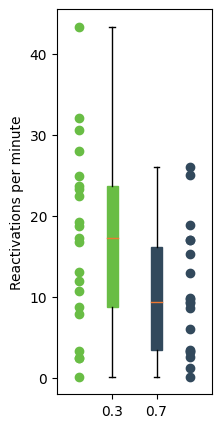

In [30]:
fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(nrem_reactivations_per_min)), nrem_reactivations_per_min, 'o', color = '#69BD45')
ax.boxplot(nrem_reactivations_per_min, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))

ax.plot(np.ones(len(rem_reactivations_per_min)), rem_reactivations_per_min, 'o', color = '#32495C')
ax.boxplot([x for x in rem_reactivations_per_min if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

ax.set_ylabel('Reactivations per minute')

SaveFig('nrem_rem_rpm.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

In [31]:

import scipy

a = [x for x in nrem_reactivations_per_min if not np.isnan(x)]
b = [x for x in rem_reactivations_per_min if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))


ShapiroResult(statistic=0.969600828792177, pvalue=0.7241796937038122)
ShapiroResult(statistic=0.9324786922706558, pvalue=0.1923645134936251)
TtestResult(statistic=2.177531408216793, pvalue=0.0357183700745947, df=38.0)


# event lengths

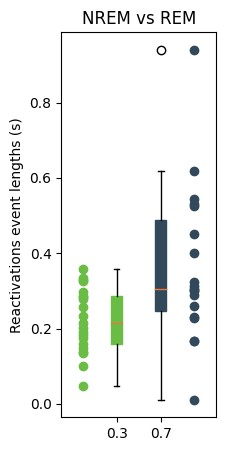

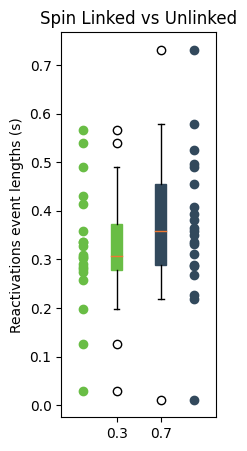

In [59]:
fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(nrem_event_lens)), nrem_event_lens, 'o', color = '#69BD45')
ax.boxplot(nrem_event_lens, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))

ax.plot(np.ones(len(rem_event_lens)), rem_event_lens, 'o', color = '#32495C')
ax.boxplot([x for x in rem_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

ax.set_ylabel('Reactivations event lengths (s)')

ax.set_title('NREM vs REM')

SaveFig('nrem_rem_event_lengths.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig, ax = plt.subplots(figsize=(2, 5))

ax.plot(np.zeros(len(linked_event_lens)), linked_event_lens, 'o', color = '#69BD45')
ax.boxplot([x for x in linked_event_lens if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))

ax.plot(np.ones(len(unlinked_event_lens)), unlinked_event_lens, 'o', color = '#32495C')
ax.boxplot([x for x in unlinked_event_lens if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

ax.set_ylabel('Reactivations event lengths (s)')

ax.set_title('Spin Linked vs Unlinked')

SaveFig('linked_unlinked_event_lengths.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')



In [35]:
a = [x for x in linked_event_lens if not np.isnan(x)]
b = [x for x in unlinked_event_lens if not np.isnan(x)]

print(scipy.stats.shapiro(a))
print(scipy.stats.shapiro(b))
# p is greater than 0.05 for both, so we fail to reject the null hypothesis that the data is normally distributed
print(scipy.stats.ttest_ind(a,b))


ShapiroResult(statistic=0.9517403951711306, pvalue=0.39428344959584416)
ShapiroResult(statistic=0.9637049595735356, pvalue=0.5936450115716083)
TtestResult(statistic=-1.1320036894253782, pvalue=0.2645452483360221, df=39.0)


# warp 

In [36]:
import scipy

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        if sum(item) > 0:
            # normalize the warp factors to sum to 1
            rels += [list(np.array(item)/sum(item))]
    return rels



bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

def extract_mean_warps(regression_df, bins_):

    f_warp_factors = []
    r_warp_factors = []

    forward = []
    reverse = []
    
    forward_total = []
    reverse_total = []

    for mouse, group in regression_df.groupby('mouse'):
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        forward_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        f_warp_factors +=[list(example_totals.values())]
        forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        reverse_total += [len(data)]
        closest_examples,example_totals = find_closest_example(data,bins_)
        r_warp_factors +=[list(example_totals.values())]
        reverse += [sum(example_totals.values())]

            
    f_warp_factors = relative_warp_values(f_warp_factors)
    r_warp_factors = relative_warp_values(r_warp_factors)
    
    return f_warp_factors, r_warp_factors, forward_total, reverse_total

def plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    for item in conactinate_nth_items(f_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'-->', color = color_, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    for item in conactinate_nth_items(r_warp_factors):
        means += [np.mean(item)]
        sems += [scipy.stats.sem(item)]
    ax.plot(means,'--<', color = color_, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)


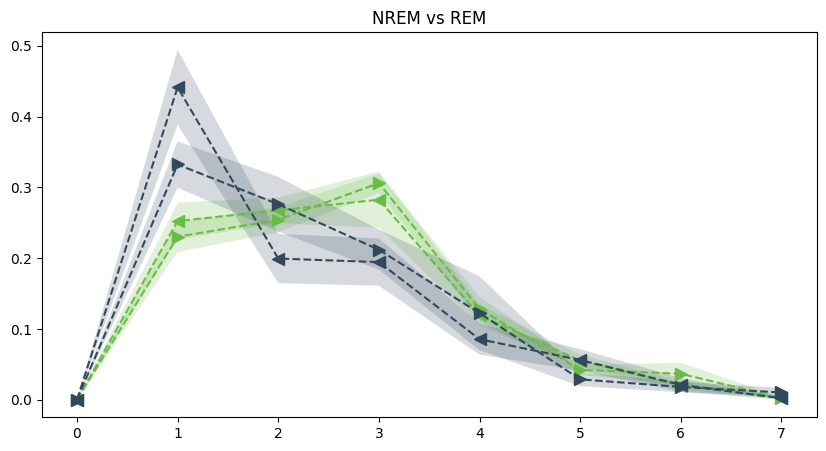

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_31540\1358348060.py:21: RuntimeWarning: divide by zero encountered in divide
  proportion_forward_v_reverse = np.array(rem_forward_total)/np.array(rem_reverse_total)


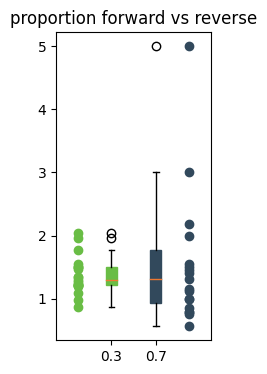

In [39]:
bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

f_warp_factors, r_warp_factors, nrem_forward_total, nrem_reverse_total = extract_mean_warps(nrem_regression_df, bins_)
color_ = '#69BD45'
fig,ax = plt.subplots(1, 1,figsize=(10, 5))
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)

f_warp_factors, r_warp_factors,  rem_forward_total, rem_reverse_total= extract_mean_warps(rem_regression_df, bins_)
color_ = '#32495C'
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)

ax.set_title('NREM vs REM')

SaveFig('rem_nrem_warps.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


fig, ax = plt.subplots(figsize=(2, 4))
proportion_forward_v_reverse = np.array(nrem_forward_total)/np.array(nrem_reverse_total)
ax.plot(np.zeros(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#69BD45')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
proportion_forward_v_reverse = np.array(rem_forward_total)/np.array(rem_reverse_total)
ax.plot(np.ones(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#32495C')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))
ax.set_title('proportion forward vs reverse')

SaveFig('rem_nrem_warps_proportion.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


In [ ]:
f_warp_factors
r_warp_factors
f_warp_factors
r_warp_factors

In [46]:
f_warp_factors, r_warp_factors, nrem_forward_total, nrem_reverse_total = extract_mean_warps(nrem_regression_df, bins_)
print(scipy.stats.shapiro([item for sublist in f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in r_warp_factors for item in sublist]))
rem_f_warp_factors, rem_r_warp_factors, rem_forward_total, rem_reverse_total = extract_mean_warps(nrem_regression_df, bins_)
print(scipy.stats.shapiro([item for sublist in rem_f_warp_factors for item in sublist]))
print(scipy.stats.shapiro([item for sublist in rem_r_warp_factors for item in sublist]))
print(' all are not normally distributed, so we will use a non-parametric test')

ShapiroResult(statistic=0.8492228585653565, pvalue=7.14192190845135e-12)
ShapiroResult(statistic=0.8062241301048108, pvalue=1.1754138220830226e-13)
ShapiroResult(statistic=0.8492228585653565, pvalue=7.14192190845135e-12)
ShapiroResult(statistic=0.8062241301048108, pvalue=1.1754138220830226e-13)
 all are not normally distributed, so we will use a non-parametric test


In [56]:
# PERMANOVA forward vs reverse diff

from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform


grouping = ['control_forwards']*len(np.vstack(f_warp_factors)) + ['control_reverse']*len(np.vstack(r_warp_factors))

# stacked_list = [list(pair) for pair in zip(group1, group2)]

# data is stacked so that each row is a sample (animal) and each colum is a variable/test

pairwise_distances = pdist(np.asarray(f_warp_factors+r_warp_factors), metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)

ImportError: cannot import name 'intp' from 'numpy._core' (c:\miniconda\Lib\site-packages\numpy\_core\__init__.py)

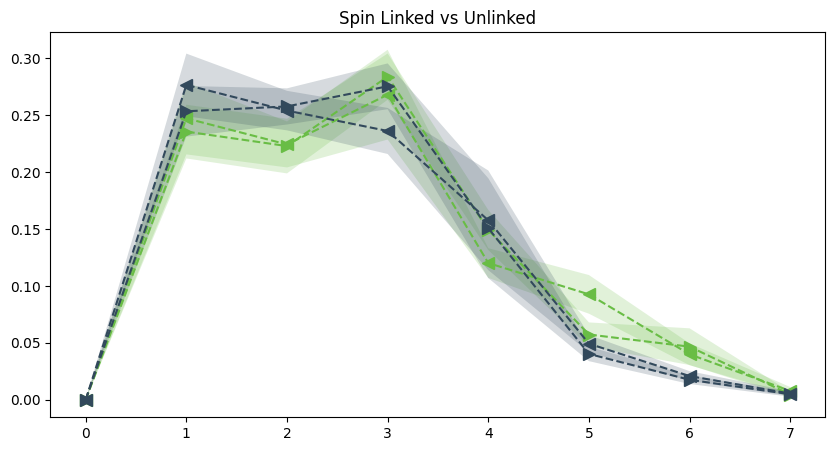

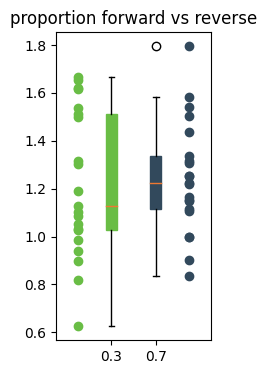

In [58]:
bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

f_warp_factors, r_warp_factors, linked_forward_total, linked_reverse_total = extract_mean_warps(linked_regression_df, bins_)
color_ = '#69BD45'
fig,ax = plt.subplots(1, 1,figsize=(10, 5))
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)

f_warp_factors, r_warp_factors, unlinked_forward_total, unlinked_reverse_total = extract_mean_warps(unlinked_regression_df, bins_)
color_ = '#32495C'
plot_warp_factors(ax, f_warp_factors, r_warp_factors, bins_, color_)

ax.set_title('Spin Linked vs Unlinked')

SaveFig('linked_unlinked_warps.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig, ax = plt.subplots(figsize=(2, 4))

proportion_forward_v_reverse = np.array(linked_forward_total)/np.array(linked_reverse_total)
ax.plot(np.zeros(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#69BD45')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))

proportion_forward_v_reverse = np.array(unlinked_forward_total)/np.array(unlinked_reverse_total)
ax.plot(np.ones(len(proportion_forward_v_reverse)),proportion_forward_v_reverse,'o', color = '#32495C')
ax.boxplot([x for x in proportion_forward_v_reverse if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

ax.set_title('proportion forward vs reverse')

SaveFig('linked_unlinked_warps_proportion.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

# reactivation rate vs time 

In [116]:
def plot_decay(nrem_binned_rate,nrem_bins_relative_so,rem_binned_rate,rem_bins_relative_so,color_1, color_2, title_):
    fig,ax = plt.subplots(1, 1,figsize=(7, 5))
    AA_rate = []
    AA_post_so_time = []
    times = []
    rates = []
    for i,item in enumerate(nrem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(nrem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_1, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
        
    AA_rate = []
    AA_post_so_time = []
    times_2 = []
    rates_2 = []
    for i,item in enumerate(rem_binned_rate):
        across_chunks_x = []
        across_chunks_y = []
        for e,chunk_item in enumerate(item):
            #mean for each time series across chunks
            across_chunks_x += [np.mean(rem_bins_relative_so[i][e])]
            across_chunks_y += [np.mean(chunk_item)]
        AA_rate+=[across_chunks_y]
        AA_post_so_time+=[across_chunks_x]
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = color_2, alpha = 1, markersize = 10, markeredgewidth = 0)
        # save out stuff for plot 2
        rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
        times_2 += across_chunks_y[0:-1]
        rates_2 += list(rate_change_per_min)
        
    ax.set_title(title_)
    ax.set_xlabel('time after sleep onset (mins)')
    
    SaveFig(title_+'decay.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

    fig,ax = plt.subplots(1, 1,figsize=(5, 5))                
    sns.regplot(x=times, y=rates, ax = ax, color = color_1,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    sns.regplot(x=times_2, y=rates_2, ax = ax, color = color_2,scatter_kws={'s': 160, 'alpha': 0.3,'linewidths': 0})
    ax.set_xlabel('starting rate')
    ax.set_ylabel('rate change per minute')
    ax.axhline(0,0,ls ='--')
    
    group1_data = {'x': times, 'y': rates}
    group2_data = {'x': times_2, 'y': rates_2}
    SaveFig(title_+'decay_regression.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
    return group1_data, group2_data

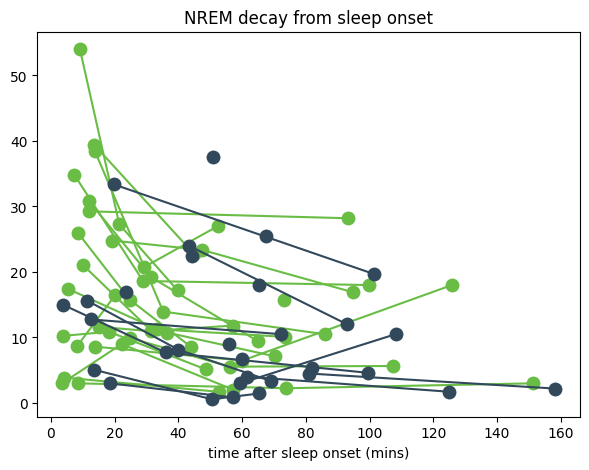

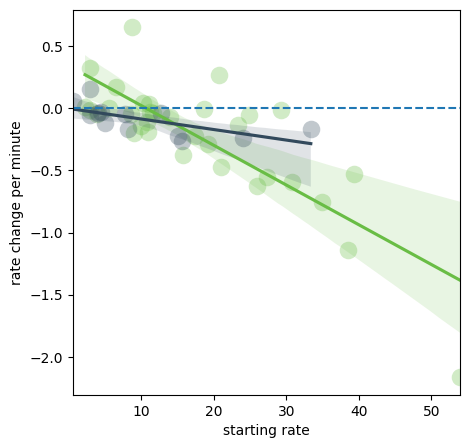

PLOT 2:
Group 1 (NREM):
model p value (f statistic) = 
1.340652912930107e-08
r2 = 
0.6523062063113081
Group 2 (REM):
model p value (f statistic) = 
0.013222789285460201
r2 = 
0.44160045646520263


In [117]:
group1_data, group2_data = plot_decay(nrem_binned_rate,nrem_bins_relative_so,rem_binned_rate,rem_bins_relative_so, '#69BD45','#32495C','NREM decay from sleep onset')

###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (NREM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (REM):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)




In [112]:
from typing import List, Union
import math

# Define a type for nested lists of numbers
Nested = Union[float, List['Nested']]

def flatten(data: Nested) -> List[float]:
    """Recursively pull out all numeric values into a flat list."""
    if isinstance(data, list):
        vals = []
        for item in data:
            vals.extend(flatten(item))
        return vals
    else:
        return [data]

def compute_stats(flat_vals: List[float]) -> (float, float):
    """Return mean and standard deviation of a list of numbers."""
    n = len(flat_vals)
    mean = sum(flat_vals) / n
    var  = sum((x - mean)**2 for x in flat_vals) / n
    return mean, math.sqrt(var)

def zscoreize(data: Nested, mean: float, std: float) -> Nested:
    """
    Recursively replace each numeric entry by its z-score.
    Leaves the nesting structure intact.
    """
    if isinstance(data, list):
        return [zscoreize(item, mean, std) for item in data]
    else:
        return (data - mean) / std

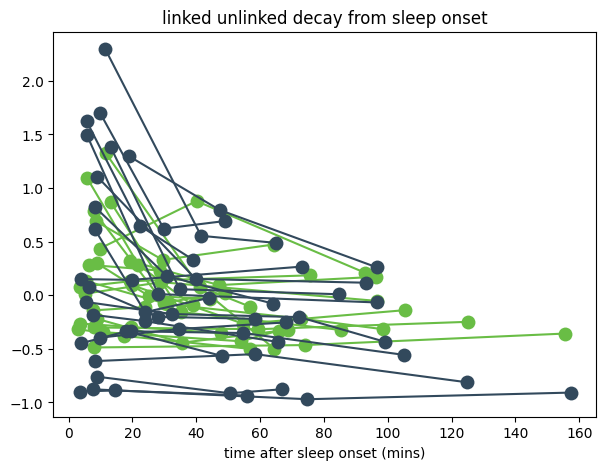

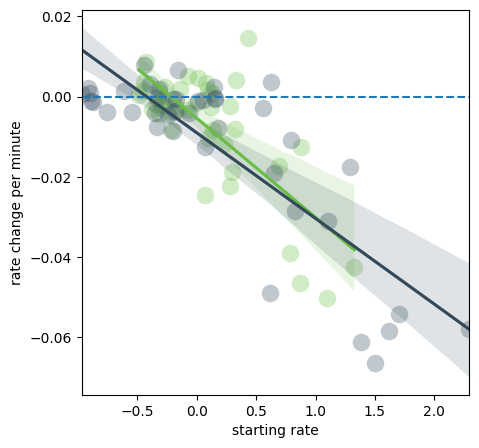

PLOT 2:
Group 1 (LINKED):
model p value (f statistic) = 
3.629252362059295e-08
r2 = 
0.5543509905440587
Group 2 (UNLINKED):
model p value (f statistic) = 
2.3606530370440656e-11
r2 = 
0.6859204535731644


In [115]:
# 1. Flatten
flat = flatten(linked_binned_rate)
# 2. Compute mean & std
mean = np.nanmean(flat)
std = np.nanstd(flat)
# 3. Recurse to z-score
normalized_linked = zscoreize(linked_binned_rate, mean, std)


# 1. Flatten
flat = flatten(unlinked_binned_rate)
# 2. Compute mean & std
mean = np.nanmean(flat)
std = np.nanstd(flat)
# 3. Recurse to z-score
normalized_unlinked = zscoreize(unlinked_binned_rate, mean, std)


group1_data, group2_data = plot_decay(normalized_linked,linked_bins_relative_so,normalized_unlinked,unlinked_bins_relative_so, '#69BD45','#32495C','linked unlinked decay from sleep onset')

###################### STATS
df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)
# Fit linear regression for Group 1
model_group1 = sm.OLS.from_formula('y ~ x', data=df1).fit()
model_group2 = sm.OLS.from_formula('y ~ x', data=df2).fit()

print('PLOT 2:')
# Print the summary of each model
print("Group 1 (LINKED):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group1.f_pvalue)
print('r2 = ')
print(model_group1.rsquared)

print("Group 2 (UNLINKED):")
# print(model_group1.summary())
print('model p value (f statistic) = ')
print(model_group2.f_pvalue)
print('r2 = ')
print(model_group2.rsquared)

# relative position

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


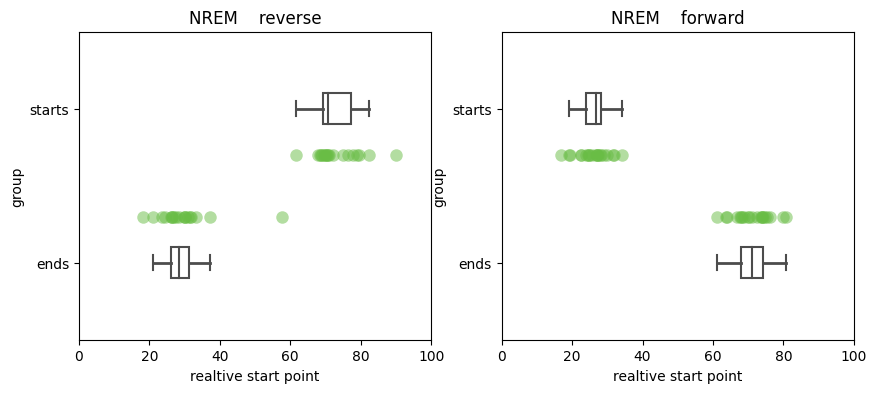

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


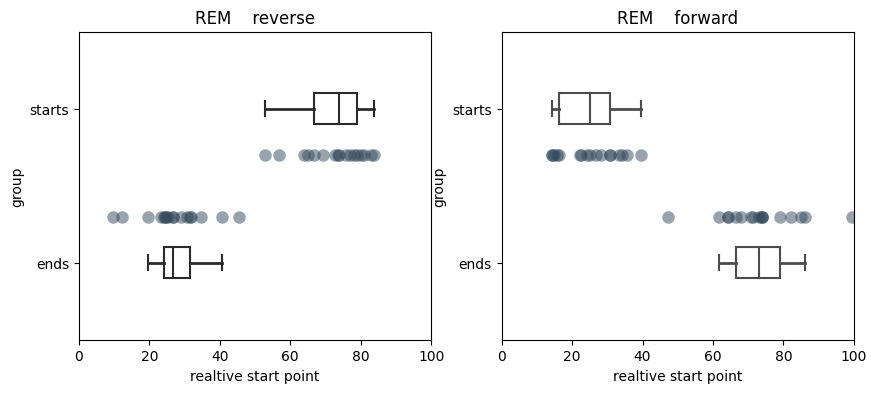

In [118]:
def extract_start_end_points(start_end_df):
    all_chunk_forward_start_mean = []
    all_chunk_forward_end_mean = []
    all_chunk_reverse_start_mean = []
    all_chunk_reverse_end_mean = []

    # s_o_d = []
    for mouse,group in start_end_df.groupby('mouse'):
        chunk_forward_start_mean = []
        chunk_forward_end_mean = []
        chunk_reverse_start_mean = []
        chunk_reverse_end_mean = []
        for diff, chunk in group.groupby('chunk_number'):
            forward_chunk = chunk[chunk.label == 'forward']
            chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
            chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

            reverse_chunk = chunk[chunk.label == 'reverse']
            chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
            chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

        all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
        
    return all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str, color_):
        
    ## plot forward start and ends

    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = color_, width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)

    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = color_, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)


        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')


    ax2.set_xlim(0,100)
    
    



fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4)) 
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(nrem_start_end_df)
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'NREM','#69BD45')
SaveFig('nrem_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(rem_start_end_df)
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'REM','#32495C')
SaveFig('rem_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')




c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


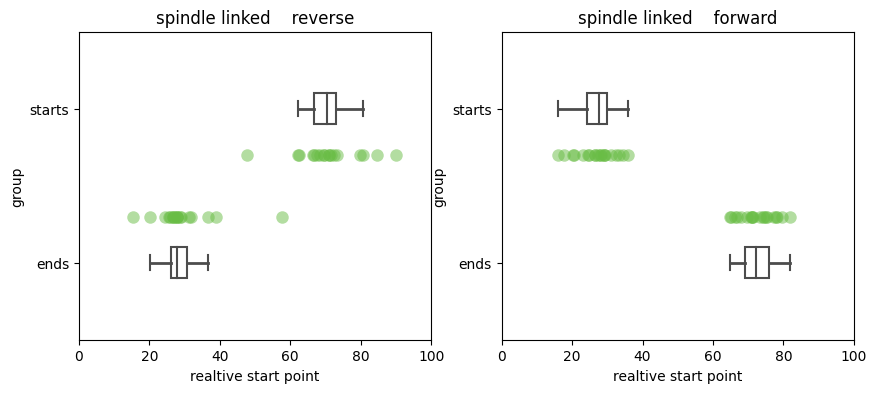

c:\miniconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\miniconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


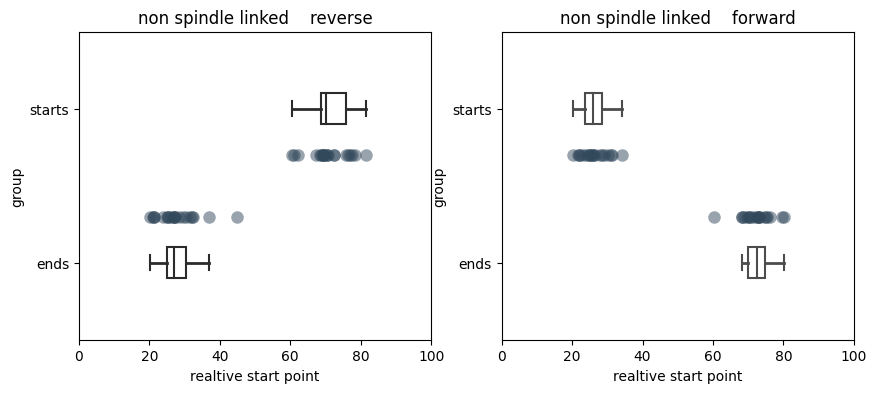

In [119]:
fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4)) 
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(linked_start_end_df)
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'spindle linked','#69BD45')
SaveFig('linked_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 4))
all_chunk_reverse_start_mean, all_chunk_forward_start_mean, all_chunk_reverse_end_mean, all_chunk_forward_end_mean = extract_start_end_points(unlinked_start_end_df)
plot_start_end_times(all_chunk_reverse_start_mean,all_chunk_forward_start_mean,all_chunk_reverse_end_mean,all_chunk_forward_end_mean,ax,ax2,'non spindle linked','#32495C')
SaveFig('uninked_start_ends.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

# coactive frequency 

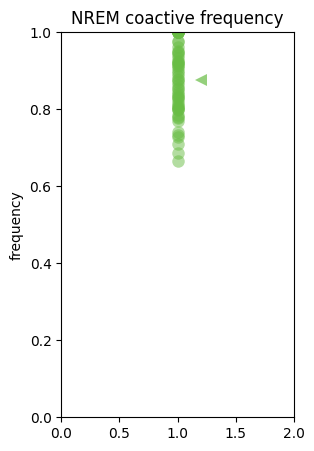

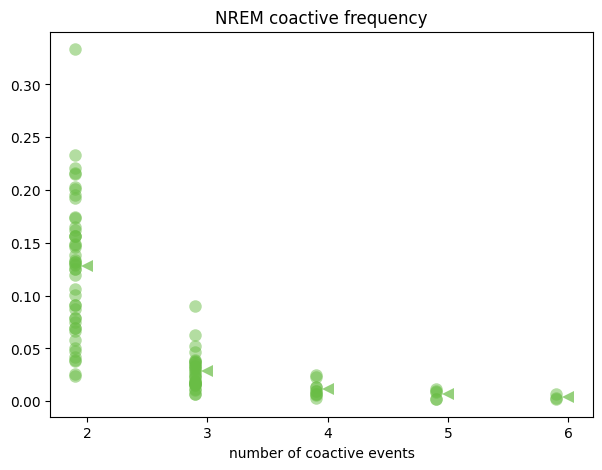

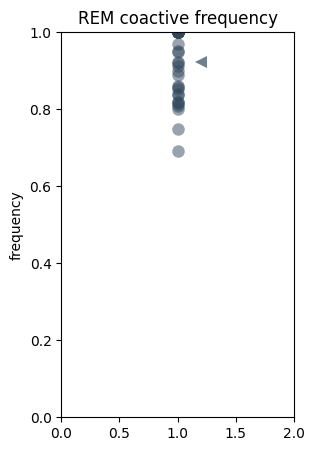

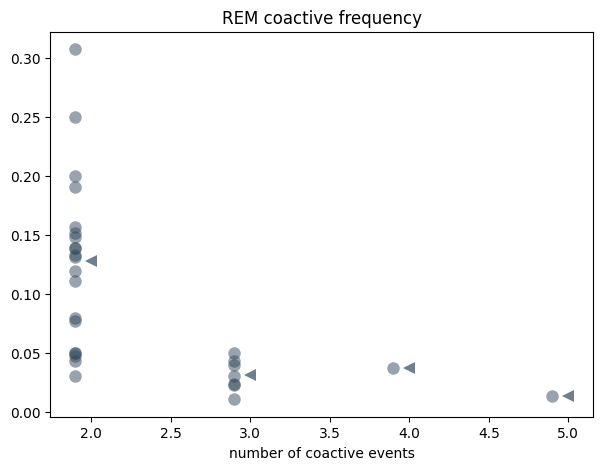

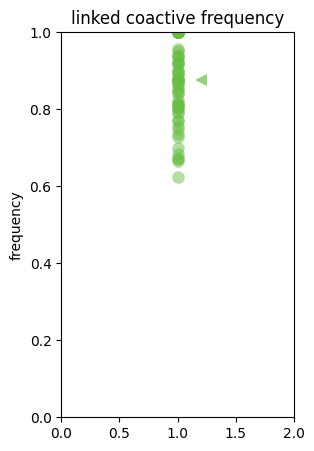

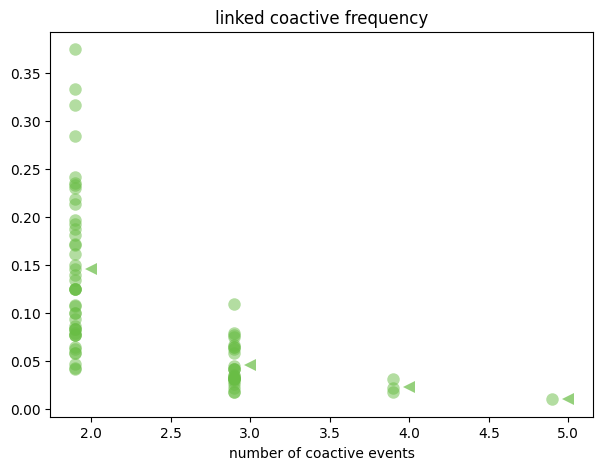

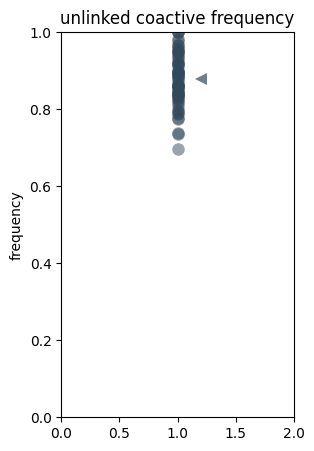

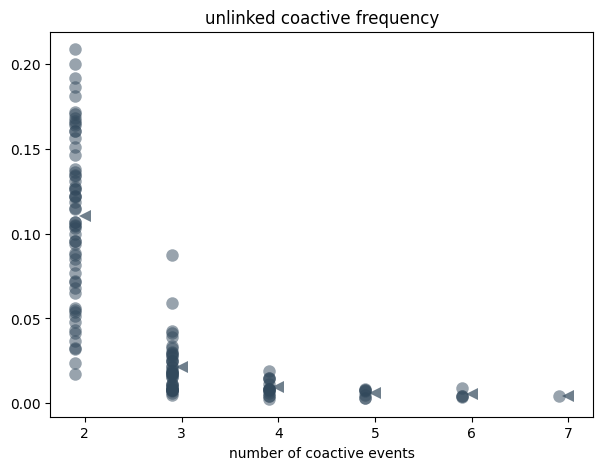

In [ ]:


# plot frequency of coactive events (1,2,3,4,etc.)


def plot_coactive_single(nrem_coactive_freqs_chunk, color_,var_string):   
    fig, ax= plt.subplots(1, 1,figsize=(3, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk:
        ax.plot(np.ones(len(nrem_coactive_freqs_chunk[1]))*(1),nrem_coactive_freqs_chunk[1],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
        x_ += [item]
        means += [np.median(nrem_coactive_freqs_chunk[1])]
        stds += [np.std(nrem_coactive_freqs_chunk[1])]
        break 
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]
    ax.plot(1.2,means[0],'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 9)
    ax.set_xlim(0,2)
    ax.set_ylabel('frequency')
    ax.set_title(var_string + ' coactive frequency')
    ax.set_ylim(0,1)


def plot_coactive_two_plus(nrem_coactive_freqs_chunk, color_,var_string):    

    fig, ax= plt.subplots(1, 1,figsize=(7, 5))
    means = []
    stds = []
    x_ = []
    for item in nrem_coactive_freqs_chunk:
        if not item == 1:
            ax.plot(np.ones(len(nrem_coactive_freqs_chunk[item]))*(item-0.1),nrem_coactive_freqs_chunk[item],'o', c = color_, alpha = 0.5, markeredgewidth = 0, markersize = 9)
            x_ += [item]
            means += [np.mean(nrem_coactive_freqs_chunk[item])]
            stds += [np.std(nrem_coactive_freqs_chunk[item])]
    means = np.array(means)[np.argsort(x_)]
    stds = np.array(stds)[np.argsort(x_)]
    x_ = np.array(x_)[np.argsort(x_)]

    ax.plot(x_,means,'<', color = color_,alpha = 0.7, markeredgewidth = 0, markersize = 8)
    ax.set_title(var_string + ' coactive frequency')
    ax.set_xlabel('number of coactive events')
    

    
plot_coactive_single(nrem_coactive_freqs, '#69BD45','NREM')
SaveFig('nrem_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_coactive_two_plus(nrem_coactive_freqs, '#69BD45','NREM')
SaveFig('nrem_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_coactive_single(rem_coactive_freqs, '#32495C','REM')
SaveFig('rem_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_coactive_two_plus(rem_coactive_freqs, '#32495C','REM')
SaveFig('rem_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_coactive_single(linked_coactive_freqs, '#69BD45','linked')
SaveFig('linked_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_coactive_two_plus(linked_coactive_freqs, '#69BD45','linked')
SaveFig('linked_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

plot_coactive_single(unlinked_coactive_freqs, '#32495C','unlinked')
SaveFig('unlinked_coactive_single.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')
plot_coactive_two_plus(unlinked_coactive_freqs, '#32495C','unlinked')
SaveFig('unlinked_coactive.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

In [124]:
len(nrem_coactive_freqs_chunk)

6

# ordered v disordered 

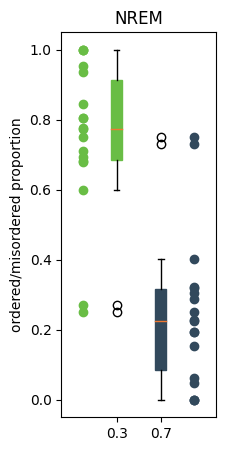

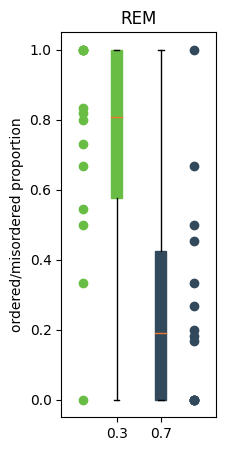

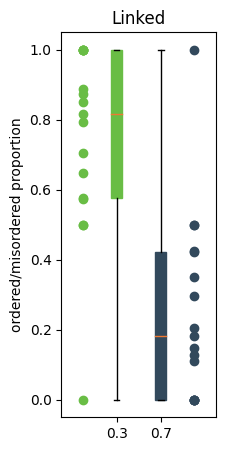

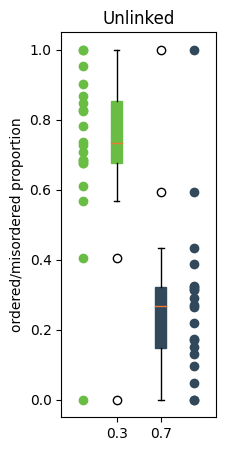

In [70]:

def plot_ordered_misrodered(nrem_ordered_misordered,var_string,var_string2):

    ordered = [item[0] for item in nrem_ordered_misordered]
    misordered = [item[1] for item in nrem_ordered_misordered]

    fig, ax = plt.subplots(figsize=(2, 5))

    ax.plot(np.zeros(len(ordered)), ordered, 'o', color = '#69BD45')
    ax.boxplot([x for x in ordered if not np.isnan(x)], positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#69BD45', color='#69BD45'), medianprops=dict(color='#EE7832'))
    ax.plot(np.ones(len(misordered)), misordered, 'o', color = '#32495C')
    ax.boxplot([x for x in misordered if not np.isnan(x)], positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#32495C', color='#32495C'), medianprops=dict(color='#EE7832'))

    ax.set_ylabel(var_string2)
    
    ax.set_title(var_string)
    

plot_ordered_misrodered(nrem_ordered_misordered,'NREM','ordered/misordered proportion')

plot_ordered_misrodered(rem_ordered_misordered,'REM','ordered/misordered proportion')

plot_ordered_misrodered(linked_ordered_misordered,'Linked','ordered/misordered proportion')

plot_ordered_misrodered(unlinked_ordered_misordered,'Unlinked','ordered/misordered proportion')

# task related 

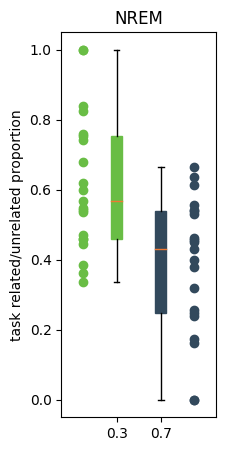

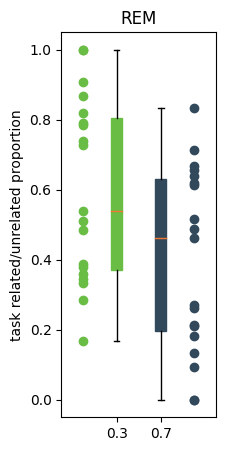

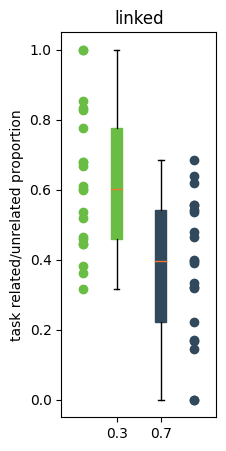

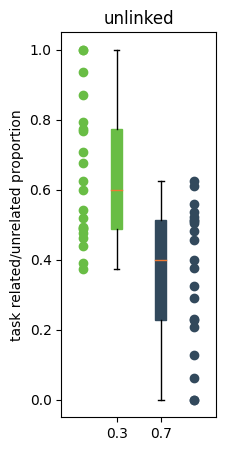

In [72]:
plot_ordered_misrodered(nrem_task_nontask,'NREM','task related/unrelated proportion')

plot_ordered_misrodered(rem_task_nontask,'REM','task related/unrelated proportion')
plot_ordered_misrodered(linked_task_nontask,'linked','task related/unrelated proportion')
plot_ordered_misrodered(unlinked_task_nontask,'unlinked','task related/unrelated proportion')

# neuron involvement rate

In [ ]:
def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for index_, item, in enumerate(awake_dat):
        for index, awake_mouse_data in enumerate(item):

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[index_][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            for bin_ in bins:
                mask = np.round(awake,1) == bin_
                if len(sleep[mask]) > min_neurons_filter:
                    if bin_ in awake_sleep_relationship:
                        awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                    else:
                        awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship




def plot_awake_sleep_relationship(awake_sleep_relationship,color_,ax):




    keys = []
    e_means = []
    sem = []
    for key in awake_sleep_relationship:
        if len(awake_sleep_relationship[key]) > 0:
            keys += [key]
    #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')

            a_s_relationship = [x for x in awake_sleep_relationship[key] if not np.isnan(x)]

            e_means += [np.mean(a_s_relationship)]
            sem += [scipy.stats.tstd(a_s_relationship)]
    ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = color_)

    upper = np.array(e_means)[np.argsort(keys)] + sem
    lower = np.array(e_means)[np.argsort(keys)] - sem
    ax.fill_between(sorted(keys),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=color_,
        linewidth=1, linestyle='dashdot', antialiased=True)

    x = np.linspace(0, 1, 10)  # Example x values
    y = x  # Since x equals y, y values are the same as x values
    plt.plot(x,y,'--')


    ax.set_ylim(0,0.8)


    ax.set_ylabel('replay proportion involvement')
    ax.set_xlabel('awake proportion involvement')

    #################################################

    from scipy.optimize import curve_fit
    from scipy.stats import t

    # Extract the bins and corresponding values
    bins = list(awake_sleep_relationship.keys())
    
    bin_centers = np.array(bins)[np.argsort(bins)]
    values = np.array([np.nanmean(awake_sleep_relationship[bin]) for bin in bins])[np.argsort(bins)]

    # Define the exponential function
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model to the data
    popt, pcov = curve_fit(exponential_model, bin_centers, values)

    # Extract the fitting parameters
    a, b = popt

    # Calculate the fitted values
    fitted_values = exponential_model(bin_centers, *popt)

    # Calculate R-squared
    residuals = values - fitted_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((values - np.mean(values))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Degrees of freedom
    dof = max(0, len(bin_centers) - len(popt))

    # Calculate standard errors of the parameters
    perr = np.sqrt(np.diag(pcov))

    # Calculate t-values for the parameters
    t_values = popt / perr

    # Calculate p-values for the parameters
    p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

    print(f'Fitted parameters: a = {a}, b = {b}')
    print(f'R-squared: {r_squared}')
    print(f'p-values: {p_values}')


    # Plot the original data and the fitted curve
    plt.scatter(bin_centers, values, label='Data')
    plt.plot(bin_centers, fitted_values, label='Fitted curve', color='red', alpha = 0.4)
    plt.xlabel('Bin Center')
    plt.ylabel('Value')




Fitted parameters: a = 0.030914061936589184, b = 3.150837545928536
R-squared: 0.9951062289855673
p-values: [2.769421795001392e-06, 1.981121044991596e-09]
Fitted parameters: a = 0.028224910990678132, b = 3.285390549191055
R-squared: 0.9973599369578955
p-values: [3.9870024082233613e-07, 1.822764161829582e-10]


Text(0.5, 1.0, 'NREM vs REM')

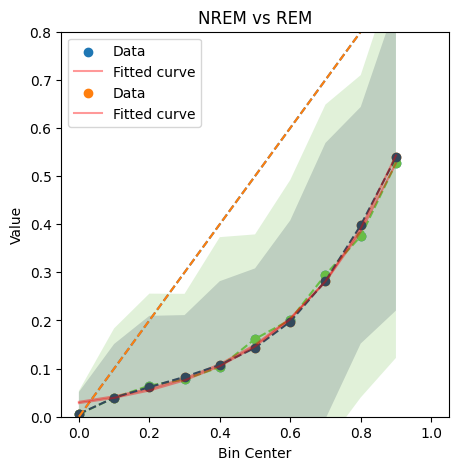

In [147]:
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,nrem_sleep_seqbyseq_neuron_involvements)
plot_awake_sleep_relationship(awake_sleep_relationship,'#69BD45',ax)
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,rem_sleep_seqbyseq_neuron_involvements)
plot_awake_sleep_relationship(awake_sleep_relationship,'#32495C',ax)
ax.set_title('NREM vs REM')

Fitted parameters: a = 0.030852683278432335, b = 3.1473243261540635
R-squared: 0.9965700242082892
p-values: [6.65464237270541e-07, 4.561246935708141e-10]
Fitted parameters: a = 0.027493130606998657, b = 3.3195996583830674
R-squared: 0.9968726287728932
p-values: [8.341205000039764e-07, 3.550044702649302e-10]


Text(0.5, 1.0, 'Linked vs unlinked')

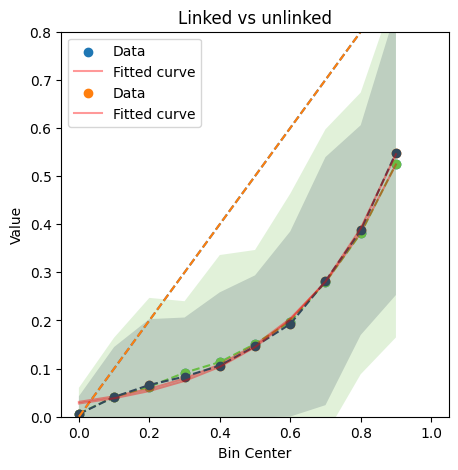

In [148]:
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,linked_sleep_seqbyseq_neuron_involvements)
plot_awake_sleep_relationship(awake_sleep_relationship,'#69BD45',ax)
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(awake_seqbyseq_neuron_involvements,unlinked_sleep_seqbyseq_neuron_involvements)
plot_awake_sleep_relationship(awake_sleep_relationship,'#32495C',ax)
ax.set_title('Linked vs unlinked')
